# Model Implementation

We have decided to try out one statistical model and one neural model for plausibility classification. <br>
For statistical model, we use a **percepron**. We import the implementation from *scikit-learn* library. <br>
For the neural model, we take **RoBERTa**. Here, we use *transformers* library. <br>

In [33]:
# set the visible CUDA device, so that Trainer for finetuning only uses one.
# Change os.environ["CUDA_VISIBLE_DEVICES"] to number of an available GPU

import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [34]:
import json
import csv
import sklearn
from sklearn.linear_model import Perceptron
from sklearn.metrics import ConfusionMatrixDisplay, accuracy_score, roc_auc_score
from sklearn.preprocessing import label_binarize
import nltk
from nltk.tokenize import word_tokenize
nltk.download('punkt')
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
import evaluate
import numpy as np
from transformers import AutoTokenizer, Trainer, TrainingArguments, DefaultDataCollator, AutoModelForSequenceClassification, pipeline
from datasets import Dataset, Value, ClassLabel, Features
import pandas as pd
import matplotlib.pyplot as plt

[nltk_data] Downloading package punkt to /home/martin/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## General data loading

In [35]:
path_adept = "datasets/adept/train-dev-test-split"
path_pap = "datasets/pap/train-dev-test-split"

# adept
def no_label(dictionary):
    return {key: value for key, value in dictionary.items() if key!="label"}
with open(path_adept+"/train.json", "r", encoding="utf-8") as file:
    adept_train = json.load(file)    
with open(path_adept+"/val.json", "r", encoding="utf-8") as file:
    adept_val = json.load(file)   
with open(path_adept+"/test.json", "r", encoding="utf-8") as file:
    adept_test = json.load(file)

# pap with multiclasses
with open(path_pap + "/multiclass/train.csv") as file:
    pap_multi_train = list(csv.DictReader(file))
with open(path_pap + "/multiclass/dev.csv") as file:
    pap_multi_dev = list(csv.DictReader(file))
with open(path_pap + "/multiclass/test.csv") as file:
    pap_multi_test = list(csv.DictReader(file))

# pap with binary labels
with open(path_pap + "/binary/train.csv") as file:
    pap_bin_train = list(csv.DictReader(file))
with open(path_pap + "/binary/dev.csv") as file:
    pap_bin_dev = list(csv.DictReader(file))
with open(path_pap + "/binary/test.csv") as file:
    pap_bin_test = list(csv.DictReader(file))

## Perceptron

In [36]:
# data-label splits 
# adept
adept_train_data = [no_label(instance) for instance in adept_train]
adept_train_labels = [instance['label'] for instance in adept_train]
adept_val_data = [no_label(instance) for instance in adept_val]
adept_val_labels = [instance['label'] for instance in adept_val]
adept_test_data = [no_label(instance) for instance in adept_test]
adept_test_labels = [instance['label'] for instance in adept_test]

# pap with multiclasses
pap_multi_train_data = [instance['text'] for instance in pap_multi_train]
pap_multi_train_labels = [instance['label'] for instance in pap_multi_train]
pap_multi_dev_data = [instance['text'] for instance in pap_multi_dev]
pap_multi_dev_labels = [instance['label'] for instance in pap_multi_dev]
pap_multi_test_data = [instance['text'] for instance in pap_multi_test]
pap_multi_test_labels = [instance['label'] for instance in pap_multi_test]

# pap with binary labels
pap_bin_train_data = [instance['text'] for instance in pap_bin_train]
pap_bin_train_labels = [instance['label'] for instance in pap_bin_train]
pap_bin_dev_data = [instance['text'] for instance in pap_bin_dev]
pap_bin_dev_labels = [instance['label'] for instance in pap_bin_dev]
pap_bin_test_data = [instance['text'] for instance in pap_bin_test]
pap_bin_test_labels = [instance['label'] for instance in pap_bin_test]

#### Get sentence vectors from Doc2Vec

In [37]:
# tokenize
def tokenize(sentences):
    tokenized = []

    for sentence in sentences:
        tokenize = word_tokenize(sentence.lower())
        tokenized.append(tokenize)
    
    return tokenized

# create a function to get sentence vector
def get_vector(tokenized_sentences):

    # train the Doc2vec model
    tagged_data = [TaggedDocument(d, [i]) for i, d in enumerate(tokenized_sentences)]
    model = Doc2Vec(vector_size=25,min_count=2, epochs=70) # words have to appear at least 2 time to be created in a vocab list
    model.build_vocab(tagged_data)
    model.train(tagged_data,
                total_examples=model.corpus_count,
                epochs=model.epochs)
    
    # get the document vectors
    document_vectors = [model.infer_vector(sentence) for sentence in tokenized_sentences]

    return document_vectors

### adept

In [38]:
# extract only sentence 2
def extract_sentence2(data):
    adept_sentences = []
    for item in data:
        adept_sentences.append(item['sentence2'])

    return adept_sentences


# get document vector for train set
adept_train_sentences = extract_sentence2(adept_train_data)
adept_train_tokenized = tokenize(adept_train_sentences)
adept_train_document_vectors = get_vector(adept_train_tokenized)


#  print example document vectors from adept
for i, doc in enumerate(adept_train_sentences[:2]):
    print("Document", i+1, ":", doc)
    print("Vector:", adept_train_document_vectors[i])
    print()

# train models (with early stopping)
adept_classifier = Perceptron(tol=1e-3, random_state=0, early_stopping=True)
adept_classifier.fit(adept_train_document_vectors, adept_train_labels)

# print mean accuracy for train set
print("Mean accuracy of the training set:")
print(f"adept multi-classes model: {adept_classifier.score(adept_train_document_vectors, adept_train_labels)}")

# get document vectors for val set
adept_val_sentences = extract_sentence2(adept_val_data)
adept_val_tokenized = tokenize(adept_val_sentences)
adept_val_document_vectors = get_vector(adept_val_tokenized)

# test model with val set
adept_val_pred = adept_classifier.predict(adept_val_document_vectors)
print("Accuracy of val sets:")
print(f'ADEPT multi-classes model: {accuracy_score(adept_val_labels, adept_val_pred)}')

# # get document vector for test set
adept_test_sentences = extract_sentence2(adept_test_data)
adept_test_tokenized = tokenize(adept_test_sentences)
adept_test_document_vectors = get_vector(adept_test_tokenized)

# # test models with test set
adept_test_pred = adept_classifier.predict(adept_test_document_vectors)
with open('adept_perceptron_predictions.csv', 'w') as f:
    f.write('sentence;predicted_label\n')
    for sent, prediction in zip(adept_test_sentences, adept_test_pred.tolist()):
        f.write(sent + ';' + str(prediction) + '\n')

print("Accuracy of test sets:")
print(f'ADEPT multi-classes model: {accuracy_score(adept_test_labels, adept_test_pred)}')

Document 1 : The effect of additional sleeping is rejuvenation.
Vector: [-0.6961173  -0.07669522  0.06725418 -0.5844058  -0.37391746 -0.10531234
  0.2351421   0.47105277 -0.8755587  -0.42271227  0.21654005 -0.12989043
  0.01966191  0.25882545  0.07930464  0.29986334 -0.02194019  0.37123767
 -0.19798402  0.00586631  0.43431377  0.45250988  0.1708536  -0.08991288
 -0.08982003]

Document 2 : A regular toothbrush is for fresh breath.
Vector: [-0.43144014  0.9223216  -0.6636249  -0.09425359 -0.10583428 -0.81819904
  0.80760527  0.43811214 -0.22152773 -0.57730293  0.00991216 -0.7552751
 -0.01979093 -0.05600656 -0.5917845  -0.33114555 -0.06478009  0.9568852
 -0.06909798 -0.05480166  0.24075851 -0.6654001   0.83404076  0.5585476
  0.35953704]

Mean accuracy of the training set:
adept multi-classes model: 0.5660874961216258
Accuracy of val sets:
ADEPT multi-classes model: 0.6468032278088144
Accuracy of test sets:
ADEPT multi-classes model: 0.6668734491315137


### pap

In [39]:
# get document vector for train set
pap_bin_train_tokenized = tokenize(pap_bin_train_data)
pap_bin_train_document_vectors = get_vector(pap_bin_train_tokenized)

pap_multi_train_tokenized = tokenize(pap_multi_train_data)
pap_multi_train_document_vectors = get_vector(pap_multi_train_tokenized)

#  print the example document vectors from pap
for i, doc in enumerate(pap_bin_train_data[:2]):
    print("Document", i+1, ":", doc)
    print("Vector:", pap_bin_train_document_vectors[i])
    print()

# train models
pap_bin_classifier = Perceptron(tol=1e-3, random_state=0)
pap_bin_classifier.fit(pap_bin_train_document_vectors, pap_bin_train_labels)

pap_multi_classifier = Perceptron(tol=1e-3, random_state=0)
pap_multi_classifier.fit(pap_multi_train_document_vectors, pap_multi_train_labels)

# print mean accuracy for train set
print("Mean accuracy of the training set:")
print(f"pap binary model: {pap_bin_classifier.score(pap_bin_train_document_vectors, pap_bin_train_labels)}")
print(f"pap multi-class model: {pap_multi_classifier.score(pap_multi_train_document_vectors, pap_multi_train_labels)}")

# testing binary model with dev set
pap_bin_dev_tokenized = tokenize(pap_bin_dev_data)
pap_bin_dev_document_vectors = get_vector(pap_bin_dev_tokenized)
pap_bin_dev_pred = pap_bin_classifier.predict(pap_bin_dev_document_vectors)

# testing multi-class models with dev set
pap_multi_dev_tokenized = tokenize(pap_multi_dev_data)
pap_multi_dev_document_vectors = get_vector(pap_multi_dev_tokenized)
pap_multi_dev_pred = pap_multi_classifier.predict(pap_multi_dev_document_vectors)

# print accuracy
print("Accuracy of dev sets:")
print(f'pap binary model: {accuracy_score(pap_bin_dev_labels, pap_bin_dev_pred)}')
print(f'pap multi-class model: {accuracy_score(pap_multi_dev_labels, pap_multi_dev_pred)}')

# # testing binary model with test set
pap_bin_test_tokenized = tokenize(pap_bin_test_data)
pap_bin_test_document_vectors = get_vector(pap_bin_test_tokenized)
pap_bin_test_pred = pap_bin_classifier.predict(pap_bin_test_document_vectors)

with open('pap_bin_perceptron_predictions.csv', 'w') as f:
    f.write('sentence,predicted_label\n')
    for sent, prediction in zip(pap_bin_test_data, pap_bin_test_pred.tolist()):
        f.write(sent + ',' + str(prediction) + '\n')

# # testing multi-class models with test set
pap_multi_test_tokenized = tokenize(pap_multi_test_data)
pap_multi_test_document_vectors = get_vector(pap_multi_test_tokenized)
pap_multi_test_pred = pap_bin_classifier.predict(pap_multi_test_document_vectors)

with open('pap_multi_perceptron_predictions.csv', 'w') as f:
    f.write('sentence,predicted_label\n')
    for sent, prediction in zip(pap_multi_test_data, pap_multi_test_pred.tolist()):
        f.write(sent + ',' + str(prediction) + '\n')

# print accuracy
print("Accuracy of test sets:")
print(f'pap binary model: {accuracy_score(pap_bin_test_labels, pap_bin_test_pred)}')
print(f'pap multi-class model: {accuracy_score(pap_multi_test_labels, pap_multi_test_pred)}')

Document 1 : event occurs year
Vector: [ 0.28233284  0.04954379  0.16533929 -0.34320468 -0.08998516 -0.18389662
  0.31326807  0.39751092  0.0052392  -0.41802603  0.21100833 -0.08489093
 -0.06006292  0.11309139 -0.36123013  0.52481467  0.33098006 -0.19439434
 -0.19194964  0.19148807  0.05928874  0.20479481  0.18891476  0.15458448
  0.48108602]

Document 2 : tortoise brings limb
Vector: [ 0.351537    0.022253    0.10919416 -0.3845272  -0.17515829 -0.12565927
  0.37557638  0.36184394  0.00363163 -0.4223897   0.21047516 -0.10207937
 -0.03482723  0.13614942 -0.4224838   0.5128126   0.35630327 -0.17363293
 -0.22952853  0.21627757  0.01363221  0.25009552  0.19937404  0.18027058
  0.40915707]

Mean accuracy of the training set:
pap binary model: 0.6927083333333334
pap multi-class model: 0.37037037037037035
Accuracy of dev sets:
pap binary model: 0.5
pap multi-class model: 0.28703703703703703
Accuracy of test sets:
pap binary model: 0.5185185185185185
pap multi-class model: 0.125


## RoBERTa

fine-tuning process referenced here: https://huggingface.co/docs/transformers/main_classes/trainer

### adept

In [40]:
##### dataset creation - adept

adept_train_dict = {
    'label': [instance['label'] for instance in adept_train],
    'text': [instance['sentence2'] for instance in adept_train]
}
adept_val_dict = {
    'label': [instance['label'] for instance in adept_val],
    'text': [instance['sentence2'] for instance in adept_val]
}
adept_test_dict = {
    'label': [instance['label'] for instance in adept_test],
    'text': [instance['sentence2'] for instance in adept_test]
}

adept_train_set = Dataset.from_dict(adept_train_dict)
adept_val_set = Dataset.from_dict(adept_val_dict)

In [41]:
# Loading model
# remove "device_map" if GPU not used

tokenizer = AutoTokenizer.from_pretrained("roberta-base", device_map = 'cuda')
model = AutoModelForSequenceClassification.from_pretrained("roberta-base", num_labels=5, 
                                                          device_map = 'cuda')

def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True)

tokenized_adept_train = adept_train_set.map(tokenize_function, batched=True)
tokenized_adept_val = adept_val_set.map(tokenize_function, batched=True)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.weight', 'classifier.out_proj.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Map: 100%|██████████| 1611/1611 [00:00<00:00, 12141.85 examples/s]


In [42]:
# Fine-Tuning using Trainer
accuracy = evaluate.load("accuracy")
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return accuracy.compute(predictions=predictions, references=labels)

training_args = TrainingArguments(
    output_dir="./output_models",
    save_strategy="epoch",
    evaluation_strategy="epoch",
    metric_for_best_model="accuracy",
    learning_rate=3e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=32,
    num_train_epochs=3,
    gradient_accumulation_steps=4,
    weight_decay=0.01
)

data_collator = DefaultDataCollator()

trainer = Trainer(
    model=model,
    tokenizer=tokenizer,
    args=training_args,
    data_collator=data_collator,
    train_dataset=tokenized_adept_train,
    eval_dataset=tokenized_adept_val,
    compute_metrics=compute_metrics,
)

# training
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.861469,0.700186
2,0.908300,0.867155,0.698324
3,0.755800,0.891847,0.696462


Checkpoint destination directory ./output_models/checkpoint-403 already exists and is non-empty.Saving will proceed but saved results may be invalid.
Checkpoint destination directory ./output_models/checkpoint-806 already exists and is non-empty.Saving will proceed but saved results may be invalid.
Checkpoint destination directory ./output_models/checkpoint-1209 already exists and is non-empty.Saving will proceed but saved results may be invalid.


TrainOutput(global_step=1209, training_loss=0.8083190539338748, metrics={'train_runtime': 2308.5768, 'train_samples_per_second': 16.753, 'train_steps_per_second': 0.524, 'total_flos': 1.0176357277937664e+16, 'train_loss': 0.8083190539338748, 'epoch': 3.0})

In [43]:
# final evaluation
trainer.evaluate()

{'eval_loss': 0.8918473720550537,
 'eval_accuracy': 0.6964618249534451,
 'eval_runtime': 32.1504,
 'eval_samples_per_second': 50.108,
 'eval_steps_per_second': 1.586,
 'epoch': 3.0}

Training results (Example) <br>
(takes around 30min on cuda)

initial evaluation: <br>

| eval_loss        | eval_accuracy    | eval_runtime | eval_samples_per_second | eval_steps_per_second |
|------------------|------------------|--------------|-------------------------|-----------------------|
| 1.5099514722824097 | 0.6641837368094351 | 18.7982  | 85.7        | 2.713        |

training output:

| Epoch         | Training Loss    | Validation Loss | Accuracy        |
|---------------|------------------|-----------------|-----------------|
| 1             | No log           | 0.861079        | 0.705152        |
| 2             | 0.905100         | 0.851406        | 0.698945        |
| 2             | 0.742600         | 0.882088        | 0.700186        |

final evaluation (after 3 epochs): <br>

| eval_loss        | eval_accuracy    | eval_runtime | eval_samples_per_second | eval_steps_per_second |
|------------------|------------------|--------------|-------------------------|-----------------------|
| 0.8820875883102417 | 0.7001862197392924 | 18.5304  | 86.938        | 2.752        |

In [44]:
pipe = pipeline("text-classification", model=model, tokenizer=tokenizer, device_map = 'cuda')
results = pipe(adept_test_dict['text'])

adept_test_idxs = [instance['idx'] for instance in adept_test]

# save predictions as csv-file for evaluation
with open("adept_roberta_3epochs.csv", 'w') as outfile:
    outfile.write("text,predicted_label\n")
    for idx, output in zip(adept_test_idxs, results):
        # take idx 6 of label, because that is the number ('LABEL_4')
        outfile.write(f"{idx},{output['label'][6]}\n")

### pap

In [45]:
##### dataset creation - pap

pap_train_dict = {
    # decrease the label by one so it starts at 0
    'label': [int(instance['label'])-1 for instance in pap_multi_train],
    'text': [instance['text'] for instance in pap_multi_train]
}
pap_dev_dict = {
    'label': [int(instance['label'])-1 for instance in pap_multi_dev],
    'text': [instance['text'] for instance in pap_multi_dev]
}
pap_test_dict = {
    'label': [int(instance['label'])-1 for instance in pap_multi_test],
    'text': [instance['text'] for instance in pap_multi_test]
}

pap_train_set = Dataset.from_dict(pap_train_dict)
pap_dev_set = Dataset.from_dict(pap_dev_dict)

In [46]:
# Loading model (reinitialize)
# remove "device_map" if GPU not used

tokenizer = AutoTokenizer.from_pretrained("roberta-base", device_map = 'cuda')
model = AutoModelForSequenceClassification.from_pretrained("roberta-base", num_labels=5, 
                                                           problem_type="single_label_classification",
                                                          device_map = 'cuda')

def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True)

tokenized_pap_train = pap_train_set.map(tokenize_function, batched=True)
tokenized_pap_dev = pap_dev_set.map(tokenize_function, batched=True)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.weight', 'classifier.out_proj.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Map: 100%|██████████| 216/216 [00:00<00:00, 9041.61 examples/s]


In [47]:
# Fine-Tuning using trainer
accuracy = evaluate.load("accuracy")
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return accuracy.compute(predictions=predictions, references=labels)

training_args = TrainingArguments(
    output_dir="./output_models",
    save_strategy="epoch",
    evaluation_strategy="epoch",
    metric_for_best_model="accuracy",
    learning_rate=2e-5,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=32,
    num_train_epochs=5,
    weight_decay=0.01
)

data_collator = DefaultDataCollator()

trainer = Trainer(
    model=model,
    tokenizer=tokenizer,
    args=training_args,
    data_collator=data_collator,
    train_dataset=tokenized_pap_train,
    eval_dataset=tokenized_pap_dev,
    compute_metrics=compute_metrics,
)

# training
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,No log,1.410953,0.333333
2,1.322600,1.313517,0.365741
3,1.162400,1.414168,0.384259
4,0.965700,1.723106,0.356481
5,0.781700,1.892350,0.365741


Checkpoint destination directory ./output_models/checkpoint-432 already exists and is non-empty.Saving will proceed but saved results may be invalid.
Checkpoint destination directory ./output_models/checkpoint-864 already exists and is non-empty.Saving will proceed but saved results may be invalid.
Checkpoint destination directory ./output_models/checkpoint-1296 already exists and is non-empty.Saving will proceed but saved results may be invalid.
Checkpoint destination directory ./output_models/checkpoint-1728 already exists and is non-empty.Saving will proceed but saved results may be invalid.
Checkpoint destination directory ./output_models/checkpoint-2160 already exists and is non-empty.Saving will proceed but saved results may be invalid.


TrainOutput(global_step=2160, training_loss=1.0343514336480035, metrics={'train_runtime': 595.0009, 'train_samples_per_second': 14.521, 'train_steps_per_second': 3.63, 'total_flos': 2273340750888960.0, 'train_loss': 1.0343514336480035, 'epoch': 5.0})

In [48]:
# final evaluation
trainer.evaluate()

{'eval_loss': 1.8923498392105103,
 'eval_accuracy': 0.36574074074074076,
 'eval_runtime': 4.1835,
 'eval_samples_per_second': 51.631,
 'eval_steps_per_second': 1.673,
 'epoch': 5.0}

Training results (Example) <br>
(takes around 10min on cuda)

initial evaluation: <br>

| eval_loss        | eval_accuracy    | eval_runtime | eval_samples_per_second | eval_steps_per_second |
|------------------|------------------|--------------|-------------------------|-----------------------|
| 1.653960108757019 | 0.12962962962962962 | 2.9102  | 74.222        | 2.405        |

training output:

| Epoch         | Training Loss    | Validation Loss | Accuracy        |
|---------------|------------------|-----------------|-----------------|
| 1             | No log           | 1.263671        | 0.407407        |
| 2             | 1.321800         | 1.389113        | 0.337963        |
| 3             | 1.145200         | 1.457842        | 0.393519        |
| 4             | 0.958300         | 1.604203        | 0.398148        |
| 5             | 0.787800         | 1.720298        | 0.407407        |

final evaluation (after 5 epochs): <br>

| eval_loss        | eval_accuracy    | eval_runtime | eval_samples_per_second | eval_steps_per_second |
|------------------|------------------|--------------|-------------------------|-----------------------|
| 1.7202976942062378 | 0.4074074074074074 | 2.533  | 85.276        | 2.764        |

In [49]:
pipe = pipeline("text-classification", model=model, tokenizer=tokenizer)
results = pipe(pap_test_dict['text'])

# save predictions as csv-file for evaluation
with open("pap_roberta_5epochs.csv", 'w') as outfile:
    outfile.write("text,predicted_label\n")
    for sentence, output in zip(pap_test_dict['text'], results):
        # take idx 6 of label, because that is the number ('LABEL_4') and increase by one, so it corresponds to original set
        outfile.write(f"{sentence},{int(output['label'][6])+1}\n")

## Evaluation

We look at AUC-ROC scores and confusion matrices for evaluation

AUC-ROC scores were calculated with the help of: https://stackoverflow.com/questions/63303682/sklearn-multiclass-roc-auc-score

Confusion matrices were created with: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.ConfusionMatrixDisplay.html

#### Load RoBERTa model predictions

In [50]:
nn_path_adept = "datasets/adept/train-dev-test-split"

with open(nn_path_adept+"/test.json", "r", encoding="utf-8") as file:
    nn_adept_test = json.load(file) 

nn_adept_test_df = pd.DataFrame.from_dict(nn_adept_test)

nn_path_adept_predictions = "./adept_roberta_3epochs.csv"
nn_adept_predictions_df = pd.read_csv(nn_path_adept_predictions)
nn_adept_df = nn_adept_test_df.merge(nn_adept_predictions_df, left_on='idx', right_on='text')
display(nn_adept_df)
nn_path_pap = "datasets/pap/train-dev-test-split/multiclass"

nn_pap_test_df = pd.read_csv(nn_path_pap + "/test.csv")

nn_path_pap_predictions = "./pap_roberta_5epochs.csv"
nn_pap_predictions_df = pd.read_csv(nn_path_pap_predictions)
nn_pap_df = nn_pap_test_df.merge(nn_pap_predictions_df, on='text')
nn_pap_df

,sentence1,sentence2,modifier,noun,label,idx,text,predicted_label
0,Urine is tested to check for disease.,Dark urine is tested to check for disease.,dark,urine,3,2082,2082,2
1,News is relevant.,False news is relevant.,false,news,1,12641,12641,1
2,Rice is stirred.,Fresh rice is stirred.,fresh,rice,2,11485,11485,2
3,Plastic is made of carbon.,Colorful plastic is made of carbon.,colorful,plastic,2,886,886,2
4,Sometimes hiking causes a smile.,Sometimes abundant hiking causes a smile.,abundant,hiking,2,5863,5863,3
...,...,...,...,...,...,...,...,...
1607,A heater is used in the winter.,A hot heater is used in the winter.,hot,heater,2,12858,12858,3
1608,You use a tin to make ornaments.,You use a convenient tin to make ornaments.,convenient,tin,2,14438,14438,2
1609,A table is for writing at it.,A quarterly table is for writing at it.,quarterly,table,0,4931,4931,2
1610,A dollar equals four quarters.,A millionth dollar equals four quarters.,millionth,dollar,0,9189,9189,2


,text,original_label,label,predicted_label
0,film runs way,plausible,5,1
1,class welcomes reservation,plausible,5,5
2,malcontent pervades effect,implausible,5,1
3,abuser exploits atmosphere,plausible,4,5
4,film utilizes footage,plausible,5,4
...,...,...,...,...
211,leader alienates land,plausible,5,4
212,brass subverts confluence,implausible,2,1
213,owner secures trademark,plausible,5,5
214,attendee disengages norm,plausible,4,4


#### Load Perceptron model predictions

In [51]:
perc_path_adept = "datasets/adept/train-dev-test-split"
with open(perc_path_adept+"/test.json", "r", encoding="utf-8") as file:
    perc_adept_test = json.load(file) 
perc_adept_test_df = pd.DataFrame.from_dict(perc_adept_test)
perc_path_adept_predictions = "./adept_perceptron_predictions.csv"
perc_adept_predictions_df = pd.read_csv(perc_path_adept_predictions, sep=';')
perc_adept_df = perc_adept_test_df.merge(perc_adept_predictions_df, left_on='sentence2', right_on='sentence')
display(perc_adept_df)

perc_path_pap_multi = "datasets/pap/train-dev-test-split/multiclass"
perc_pap_multi_test_df = pd.read_csv(perc_path_pap_multi + "/test.csv")
perc_path_pap_multi_predictions = "./pap_multi_perceptron_predictions.csv"
perc_pap_multi_predictions_df = pd.read_csv(perc_path_pap_multi_predictions)
perc_pap_multi_df = perc_pap_multi_test_df.merge(perc_pap_multi_predictions_df, left_on='text', right_on='sentence')
display(perc_pap_multi_df)

perc_path_pap_bin = "datasets/pap/train-dev-test-split/binary"
perc_pap_bin_test_df = pd.read_csv(perc_path_pap_bin + "/test.csv")
perc_path_pap_bin_predictions = "./pap_bin_perceptron_predictions.csv"
perc_pap_bin_predictions_df = pd.read_csv(perc_path_pap_bin_predictions)
perc_pap_bin_df = perc_pap_bin_test_df.merge(perc_pap_bin_predictions_df, left_on='text', right_on='sentence')
display(perc_pap_bin_df)

,sentence1,sentence2,modifier,noun,label,idx,sentence,predicted_label
0,Urine is tested to check for disease.,Dark urine is tested to check for disease.,dark,urine,3,2082,Dark urine is tested to check for disease.,2
1,News is relevant.,False news is relevant.,false,news,1,12641,False news is relevant.,2
2,Rice is stirred.,Fresh rice is stirred.,fresh,rice,2,11485,Fresh rice is stirred.,2
3,Plastic is made of carbon.,Colorful plastic is made of carbon.,colorful,plastic,2,886,Colorful plastic is made of carbon.,2
4,Sometimes hiking causes a smile.,Sometimes abundant hiking causes a smile.,abundant,hiking,2,5863,Sometimes abundant hiking causes a smile.,2
...,...,...,...,...,...,...,...,...
1607,A heater is used in the winter.,A hot heater is used in the winter.,hot,heater,2,12858,A hot heater is used in the winter.,2
1608,You use a tin to make ornaments.,You use a convenient tin to make ornaments.,convenient,tin,2,14438,You use a convenient tin to make ornaments.,2
1609,A table is for writing at it.,A quarterly table is for writing at it.,quarterly,table,0,4931,A quarterly table is for writing at it.,2
1610,A dollar equals four quarters.,A millionth dollar equals four quarters.,millionth,dollar,0,9189,A millionth dollar equals four quarters.,2


,text,original_label,label,sentence,predicted_label
0,film runs way,plausible,5,film runs way,0
1,class welcomes reservation,plausible,5,class welcomes reservation,0
2,malcontent pervades effect,implausible,5,malcontent pervades effect,1
3,abuser exploits atmosphere,plausible,4,abuser exploits atmosphere,0
4,film utilizes footage,plausible,5,film utilizes footage,0
...,...,...,...,...,...
211,leader alienates land,plausible,5,leader alienates land,0
212,brass subverts confluence,implausible,2,brass subverts confluence,1
213,owner secures trademark,plausible,5,owner secures trademark,1
214,attendee disengages norm,plausible,4,attendee disengages norm,1


,text,original_label,label,sentence,predicted_label
0,interpretation construes title,plausible,1,interpretation construes title,1
1,mask sustains axis,implausible,0,mask sustains axis,1
2,trader ensures strategy,implausible,1,trader ensures strategy,1
3,animator comprises trip,implausible,1,animator comprises trip,1
4,welfare constructs hundred,implausible,0,welfare constructs hundred,0
...,...,...,...,...,...
211,malcontent pervades effect,implausible,1,malcontent pervades effect,1
212,realism overpowers alignment,implausible,1,realism overpowers alignment,0
213,outcome presides part,implausible,0,outcome presides part,1
214,ship collides head,plausible,1,ship collides head,1


#### Confusion Matrix - Dataset: Adept

##### RoBERTa

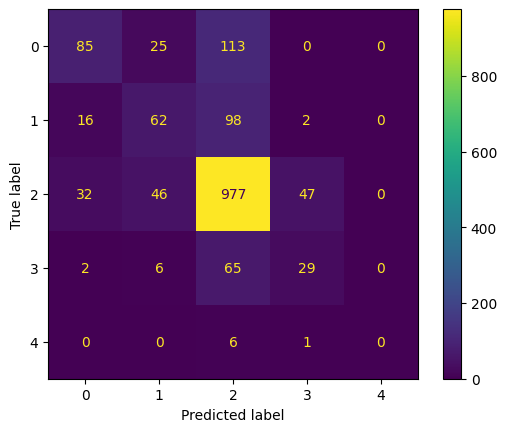

In [52]:
ConfusionMatrixDisplay.from_predictions(nn_adept_df['label'], nn_adept_df['predicted_label'])
plt.show()

##### Perceptron

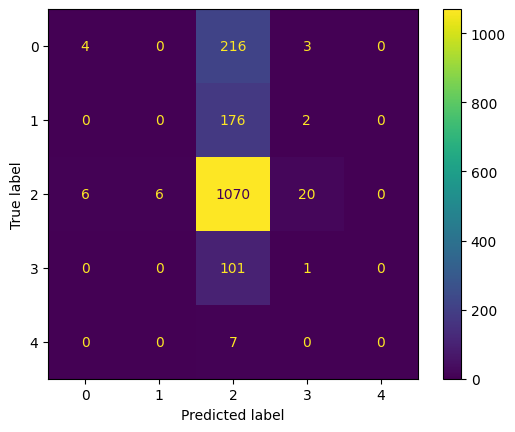

In [53]:
ConfusionMatrixDisplay.from_predictions(perc_adept_df['label'], perc_adept_df['predicted_label'])
plt.show()

#### AUC and ROC - Dataset: Adept

##### RoBERTa

In [54]:
# initialize available labels
nn_adept_labels = [0, 1, 2, 3, 4]
# list of true labels
nn_adept_test  = nn_adept_df['label'].to_list()
nn_adept_test = label_binarize(nn_adept_test, classes=nn_adept_labels)
# list of predicted labels
nn_adept_predictions = nn_adept_df['predicted_label'].to_list()
nn_adept_predictions = label_binarize(nn_adept_predictions, classes=nn_adept_labels)

roc_auc_score(nn_adept_test, nn_adept_predictions,average='macro',multi_class='ovo')

0.6224617289620515

##### Perceptron

In [55]:
# initialize available labels
perc_adept_labels = [0, 1, 2, 3, 4]
# list of true labels
perc_adept_test  = perc_adept_df['label'].to_list()
perc_adept_test = label_binarize(perc_adept_test, classes=perc_adept_labels)
# list of predicted labels
perc_adept_predictions = perc_adept_df['predicted_label'].to_list()
perc_adept_predictions = label_binarize(perc_adept_predictions, classes=perc_adept_labels)

roc_auc_score(perc_adept_test, perc_adept_predictions,average='macro',multi_class='ovo')

0.4993250825677354

#### Confusion matrix - Dataset: pap (multi_class)

##### RoBERTa

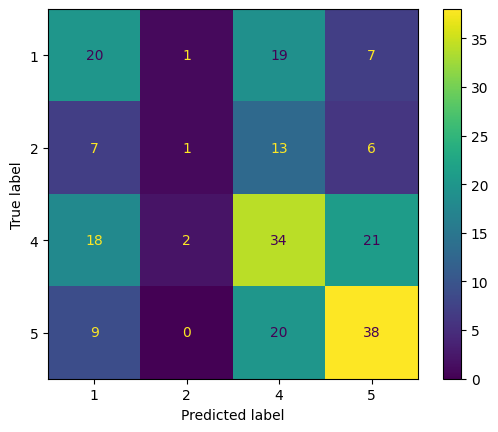

In [56]:
ConfusionMatrixDisplay.from_predictions(nn_pap_df['label'], nn_pap_df['predicted_label'])
plt.show()

##### Perceptron

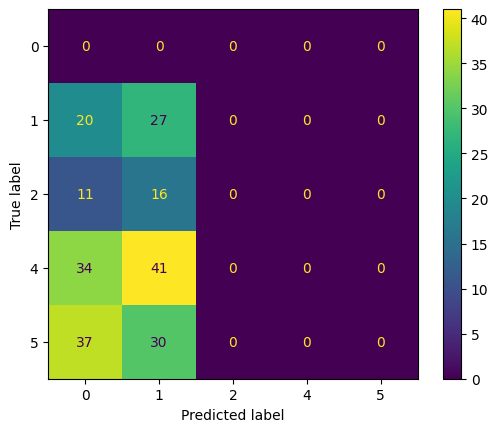

In [57]:
ConfusionMatrixDisplay.from_predictions(perc_pap_multi_df['label'], perc_pap_multi_df['predicted_label'])
plt.show()

#### AUC and ROC - Dataset: pap (multi_class)

##### RoBERTa

In [58]:
# initialize available labels
nn_pap_labels = [1, 2, 4, 5]
# list of true labels
nn_pap_test  = nn_pap_df['label'].to_list()
nn_pap_test = label_binarize(nn_pap_test, classes=nn_pap_labels)
# list of predicted labels
nn_pap_predictions = nn_pap_df['predicted_label'].to_list()
nn_pap_predictions = label_binarize(nn_pap_predictions, classes=nn_pap_labels)

roc_auc_score(nn_pap_test, nn_pap_predictions,average='macro',multi_class='ovo')

0.5836284713548205

##### Perceptron

In [59]:
# initialize available labels
perc_pap_multi_labels = [1, 2, 4, 5]
# list of true labels
perc_pap_multi_test  = perc_pap_multi_df['label'].to_list()
perc_pap_multi_test = label_binarize(perc_pap_multi_test, classes=perc_pap_multi_labels)
# list of predicted labels
perc_pap_multi_predictions = perc_pap_multi_df['predicted_label'].to_list()
perc_pap_multi_predictions = label_binarize(perc_pap_multi_predictions, classes=perc_pap_multi_labels)

roc_auc_score(perc_pap_multi_test, perc_pap_multi_predictions,average='macro',multi_class='ovo')

0.5074593982122624

#### Confusion matrix - Dataset: pap (binary)
(perceptron only)

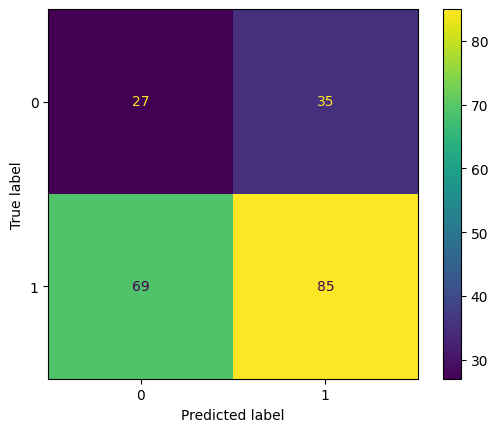

In [60]:
ConfusionMatrixDisplay.from_predictions(perc_pap_bin_df['label'], perc_pap_bin_df['predicted_label'])
plt.show()

#### AUC and ROC - Dataset: pap (binary)
(perceptron only)

In [61]:
# initialize available labels
perc_pap_bin_labels = [0, 1]
# list of true labels
perc_pap_bin_test  = perc_pap_bin_df['label'].to_list()
perc_pap_bin_test = label_binarize(perc_pap_bin_test, classes=perc_pap_bin_labels)
# list of predicted labels
perc_pap_bin_predictions = perc_pap_bin_df['predicted_label'].to_list()
perc_pap_bin_predictions = label_binarize(perc_pap_bin_predictions, classes=perc_pap_bin_labels)

roc_auc_score(perc_pap_bin_test, perc_pap_bin_predictions,average='macro')

0.4937159614578969